# P2 B - Regresión Logística
Hecho por:
- Jaime Benedi
- Miguel Sevilla

El hecho de si hay riesgo cardiovascular depende de diversos factores como por ejemplo la presión arterial y el colesterol.
1. Genera un dataset sintético que va a contener 800 instancias que representen personas. Cada persona va a tener los siguientes atributos:
    - Valores de presión arterial y colesterol. Ten en cuenta que el nivel normal de colesterol se considera por debajo de 180, aunque puede variar entre 120 y 250, y el nivel normal de presión arterial sistólica se encuentra entre 100 y 120, aunque puede variar entre 70 y 180.
    - Valores aleatorios de otro atributo que simule otros datos de la persona (pueden ser inventado).
2. Para cada instancia, calcula la probabilidad de tener problemas vasculares. Ten en cuenta las consideraciones sobre los valores de presión arterial y colesterol.
3. En base a un umbral, para cada instancia (teniendo en cuenta la probabilidad calculada en el punto 2), determina la clase de tener riesgo cardiovascular (1) o no (0).
4. Dibuja la gráfica de los datos con respecto a la presión arterial (eje X por ejemplo) y el colesterol (eje Y por ejemplo). Muestra las predicciones utilizando diferentes dibujos para cada punto. Al mostrar los datos generados, observa si guardan cierta coherencia, para que sea posible al regresor aprender. Si lo necesitas, cambia los datos generados.
5. Entrena un regresor logístico (e.g. con clase LogisticRegression) con esos datos.
6. Vuelve a dibujar la gráfica de los datos, dibujando también la curva de la regresión que separa las clases.
7. Genera regresión logística para otro conjunto de personas (500) instancias y dibuja la misma gráfica que en el punto 6. Compara el resultado de la gráfica obtenida con el nuevo conjunto de personas y con el conjunto de personas anterior.

## Librerías a usar

In [638]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Generación de datos

Definiremos la generación de datos para las variables de presión arterial, colesterol e índice de grasa corporal (elegida por nosotros). Esta variable irá en escala del 1 al 100 (por conveniencia, representamos en unidades el porcentaje), aunque esperamos acotarlo entre 10 y 60.

Para la genereación de datos, implementamos:

In [639]:
def genDataset(
    minPres : float,
    maxPres : float, 
    avgPres : float,
    funcPres,
    minCol : float,
    maxCol : float, 
    avgCol : float,
    funcCol,
    minOther : float,
    maxOther : float, 
    avgOther : float,
    labelOther : str,
    funcOther,
    size: int
) -> pd.DataFrame :
    
    xPres = np.random.normal(avgPres, min(avgPres-minPres, maxPres-avgPres)-5, size,)
    xCol = np.random.normal(avgCol, min(avgCol-minCol, maxCol-avgCol)-5, size)
    xOther = np.random.normal(avgOther, min(avgOther-minOther, maxOther-avgOther)-5, size)
    
    probRiesgo = np.vectorize(funcPres)(xPres) + funcCol(xCol) + funcOther(xOther)
    # consideremos en riesgo a todas aquellas personas con una probabilidad acumulada mayor a un medio
    riesgo = (probRiesgo > 0.5).astype(int)
            
    return pd.DataFrame({"Presion": xPres, "Colesterol" : xCol, labelOther: xOther, "Riesgo": riesgo})

Donde los criterios vienen dados por:

In [640]:
def arterial_pressure_risk(x) -> float:
    if (x < 100) :
        return (50 + (100-x))/70
    elif (x > 120) :
        return (x - 100) / 50
    else :
        return (x - 100) / 100
    
def colestherol_risk(x) -> float:
    return (x - 180) / 50
    
def fat_index_risk(x) -> float:
    return (x - 20) / 40

Bajo parametros de frontera de intervalo, media y finalmente el tamaño poblacional

In [641]:
(miniP, maxiP, avgP) = (70, 180, 110)
(miniC, maxiC, avgC) = (120, 250, 160)
(miniF, maxiF, avgF) = (10, 65, 22)
population_size = 800

In [642]:
data = genDataset(miniP, maxiP, avgP, arterial_pressure_risk, miniC, maxiC, avgC, colestherol_risk, miniF, maxiF, avgF, "Indice Grasa", fat_index_risk, population_size)
print(data)
print(data["Riesgo"].value_counts())

        Presion  Colesterol  Indice Grasa  Riesgo
0    121.834722  132.310675     18.330266       0
1    124.086228  136.943638     16.456218       0
2    121.367928  193.944519     15.384142       1
3     86.216878  215.298736     16.354988       1
4    134.782663  170.204671     20.264130       1
..          ...         ...           ...     ...
795   90.962597  171.287470     14.246622       1
796  116.103125  177.042899     19.628031       0
797  159.293474  125.392564     31.730240       0
798  115.571955  213.047721     32.285216       1
799  148.366565  172.165970     24.656630       1

[800 rows x 4 columns]
Riesgo
0    439
1    361
Name: count, dtype: int64


Vemos que hay cierto balance en la muestra generada (la mayoría de las veces por la aleatoriedad de las funciones)

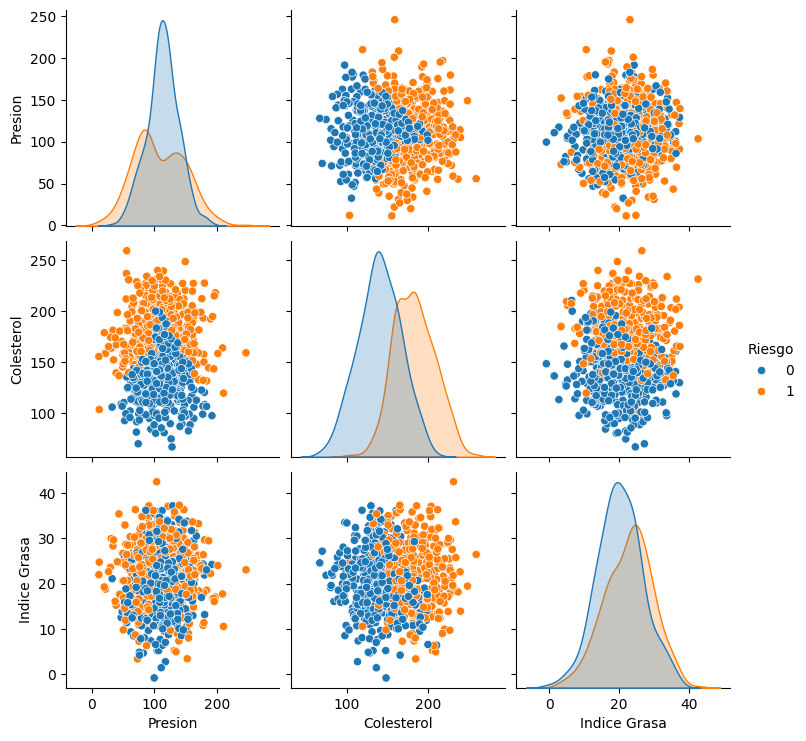

In [643]:
sns.pairplot(data, hue="Riesgo")

Observamos que donde puede haber más incoherencia es con la combinación de Índice de grasa y Presión. Entre Presión-Colesterol, Colesterol-Indice de grasa vemos una clara división

In [644]:
def plot_data(x1, x2, y, label1, label2) :
    sns.scatterplot(x=x1, y=x2, hue=y, palette=['red', 'black'])
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title("Datos")
    plt.legend(["Alto Riesgo (1)", "Bajo Riesgo (0)"])

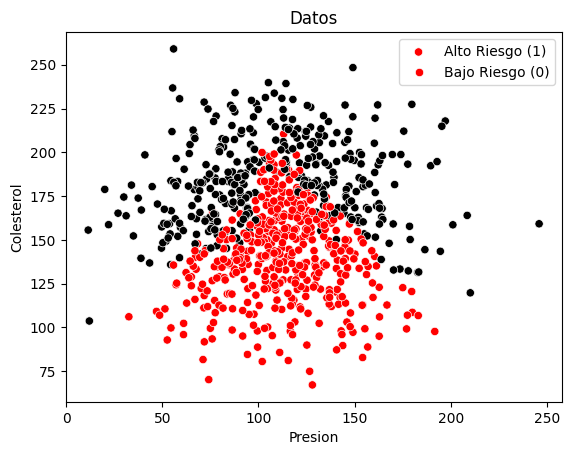

In [645]:
plot_data(data["Presion"], data["Colesterol"], data["Riesgo"], "Presion", "Colesterol")
plt.show()

## Regresión Logística

In [646]:
SEED : int = 0
modelo = LogisticRegression(random_state=SEED, C=0.37) # C == coeficiente de regularización

In [647]:
X = data[["Presion", "Colesterol", "Indice Grasa"]]
y = data ["Riesgo"]


# Dividimos la muestra en un 80% para entrenamiento, 20% para test
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [648]:
modelo.fit(xTrain, yTrain)

LogisticRegression(C=0.37, random_state=0)

In [649]:
predicciones = modelo.predict(xTest)
print("Precision del modelo: ", accuracy_score(yTest, predicciones))

Precision del modelo:  0.78125


Con un coeficiente de regularización por debajo del 0.5, conseguimos buenos resultados de predicción, como podemos observar. Esto puede deberse a que hay una ligera super posición entre las clases y este coeficiente permite evitar no sobre ajustarse a los datos de entrenamiento.

## Muestreo de datos

In [650]:
new_modelo = LogisticRegression(random_state=SEED, C=0.3)

X2 = data[["Presion", "Colesterol"]]
y2 = data["Riesgo"]
xTrain, xTest, yTrain, yTest = train_test_split(X2, y2, test_size=0.2, random_state=SEED)

new_modelo.fit(xTrain, yTrain)
print("Precision del modelo: ", accuracy_score(yTest, new_modelo.predict(xTest)))

Precision del modelo:  0.7875


In [659]:
def try_draw_contour_and_data(data : pd.DataFrame, modelo, X) -> None :
    
    x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
    y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 800), np.linspace(y_min, y_max, 800))
    smth = pd.DataFrame({"Presion":xx.ravel(), "Colesterol":yy.ravel()})
    Z = modelo.predict(smth[["Presion", "Colesterol"]])
    Z = Z.reshape(xx.shape)
    print(Z)
    print(Z.shape)

    # Graficar los puntos de datos
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data["Presion"], y=data["Colesterol"], hue=data["Riesgo"], palette=["blue", "red"], alpha=0.7)

    # Dibujar la frontera de decisión
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")

    plt.xlabel("Presión Arterial")
    plt.ylabel("Colesterol")
    plt.title("Frontera de riesgo vascular")
    plt.legend(["Alto Riesgo (1)", "Bajo Riesgo (0)"])
    #plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
(800, 800)


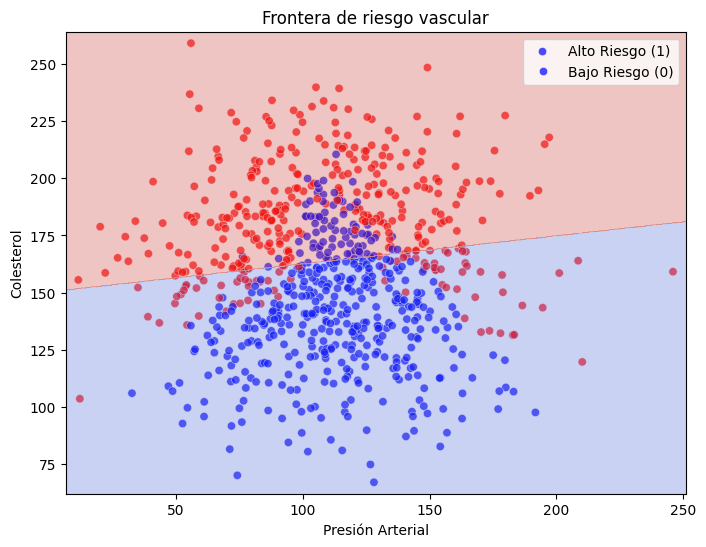

In [660]:
try_draw_contour_and_data(data, new_modelo, X2.values)